# pyFCI tutorial

This is a prototipe for a library to perform **intrinsic dimension estimation using the local full correlation integral estimator** presented in out [paper](https://www.nature.com/articles/s41598-019-53549-9).

## Installation

Clone the repository locally

    git clone https://github.com/vittorioerba/pyFCI.git

and install using pip

    cd pyFCI
    pip3 install .
    
If you want to make modifications to the source code, install by sìymlinking

    cd pyFCI
    pip3 install -e .

## Usage

We recommend using numpy arrays as often as you can.

In [1]:
# imports

import pyFCI
import numpy as np

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

Let's generate a simple dataset to play with.

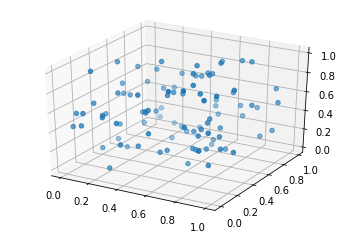

In [2]:
N = 100;
d = 3; 

dataset = np.random.rand(N,d)

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(dataset[:,0], dataset[:,1], dataset[:,2])

### Global Intrinsic Dimension Estimation (IDE)

First of all, we need to preprocess our dataset so that it has null mean, and all vectors are normalized.

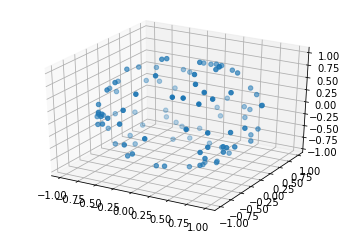

In [3]:
processed_dataset = pyFCI.center_and_normalize(dataset)

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(processed_dataset[:,0], processed_dataset[:,1], processed_dataset[:,2])

Then, we proceed to compute the **full correlation integral** (FCI).

(0, 1)

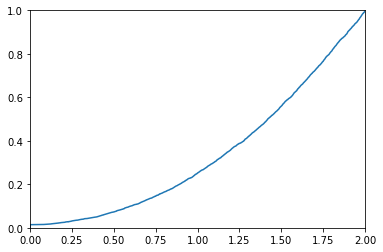

In [4]:
fci = pyFCI.FCI(processed_dataset)

fig = plt.figure()
ax = fig.add_subplot()
ax.plot(fci[:,0], fci[:,1])
ax.set_xlim([0,2])
ax.set_ylim([0,1])

Notice that if your dataset has $N$ points, the ``pyFCI.FCI()`` function will have to perform $\frac{N(N-1)}{2} \sim N^2$ operations to compute exactly the FCI.
If your dataset is large, it's better to compute an approximation of the FCI by using the ``pyFCI.FCI_MC()`` method; its second argument is gives an upper bound on the number of operations allowed (500 is a san default, anything above that will practically work as good as the exact FCI for all purposes).
Let's compare the two methods.
(**Attention:** the first run will call the numba jit compiler and will take much longer!)

In [9]:
N = 2000;
d = 10; 

dataset = np.random.rand(N,d)
processed_dataset = pyFCI.center_and_normalize(dataset);

In [10]:
%time fci = pyFCI.FCI(processed_dataset)

CPU times: user 11.9 s, sys: 29.7 ms, total: 11.9 s
Wall time: 2.3 s


In [11]:
%time fciMC = pyFCI.FCI_MC(processed_dataset, 1000)

CPU times: user 6.54 ms, sys: 70 µs, total: 6.61 ms
Wall time: 1.09 ms


(0, 1)

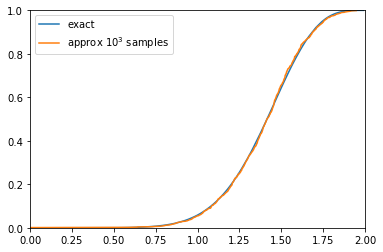

In [12]:
fig = plt.figure()
ax = fig.add_subplot()
ax.plot(fci[:,0], fci[:,1], label="exact")
ax.plot(fciMC[:,0], fciMC[:,1], label="approx $10^3$ samples")
ax.legend(loc='upper left')
ax.set_xlim([0,2])
ax.set_ylim([0,1])

Now that we have the FCI, we are ready to compute the ID of the dataset.
For a first check, one can use the ``pyFCI.analytical_FCI()`` function (notice that we need to use $d-1$, as normalizing the dataset eats away a degree of freedom):

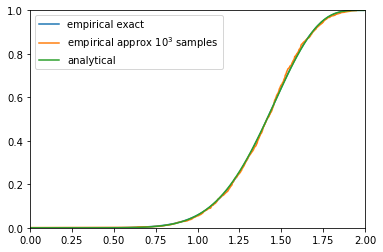

In [13]:
fig = plt.figure()
ax = fig.add_subplot()
ax.plot(fci[:,0], fci[:,1], label="empirical exact")
ax.plot(fciMC[:,0], fciMC[:,1], label="empirical approx $10^3$ samples")

xs = np.linspace(0,2,100)
ys = pyFCI.analytical_FCI(xs,d-1,1)
ax.plot(xs, ys, label="analytical")
ax.set_xlim([0,2])
ax.set_ylim([0,1])

ax.legend(loc='upper left')

To actually fit the function and recover $d$, we use ``pyFCI.fit_FCI()``.

In [14]:
fit_exact = pyFCI.fit_FCI(fci)
fit_MC = pyFCI.fit_FCI(fciMC)
print("ID estimated with exact FCI: ", fit_exact[0])
print("ID estimated with approximate FCI: ", fit_MC[0])


ID estimated with exact FCI:  10.153064067014695
ID estimated with approximate FCI:  10.619394691123722


### Local Intrinsic Dimension Estimation (IDE)

To estimate the local ID, you need to specify a local patch of your dataset.
This is done by selecting a single point in the dataset, and specifing the number of nearest neighbours that define larger and larger neighbourhoods.

In [15]:
center = np.random.randint(len(dataset))
ks = np.array([5*i for i in range(1,11)])

In [16]:
localFCI = pyFCI.local_FCI(dataset,center,ks)

In [17]:
print("   ks |Max dist|loc ID|    x0|   MSE")
with np.printoptions(precision=3, suppress=True):
    print(localFCI)

   ks |Max dist|loc ID|    x0|   MSE
[[ 5.     0.657 22.92   1.2    0.054]
 [10.     0.735 10.939  1.048  0.03 ]
 [15.     0.793  7.238  1.034  0.02 ]
 [20.     0.812 10.555  1.033  0.036]
 [25.     0.836 10.308  1.009  0.018]
 [30.     0.854  8.93   0.994  0.022]
 [35.     0.862 10.111  1.012  0.01 ]
 [40.     0.878 11.345  1.016  0.015]
 [45.     0.889  9.565  0.991  0.009]
 [50.     0.895  9.33   1.017  0.012]]


Now you can repeat for as many local centers as you like:

In [21]:
Ncenters = 30

centers = np.random.randint(len(dataset),size=Ncenters)

localFCI_multiple = np.empty(shape=(0,len(ks),5))
for i in range(Ncenters):
    localFCI = pyFCI.local_FCI(dataset,center,ks)
    localFCI_multiple = np.append( localFCI_multiple, [localFCI], axis=0 )

and you can reproduce the persistence plot show in our [paper](https://www.nature.com/articles/s41598-019-53549-9)

(0, 20)

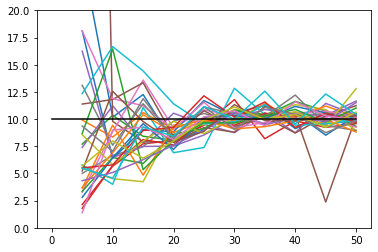

In [22]:
fig = plt.figure()
ax = fig.add_subplot()

for i in range(Ncenters):
    ax.plot(localFCI_multiple[i,:,0],localFCI_multiple[i,:,2])
    
xs = np.linspace(0,50,2)
ax.plot(xs,[10 for x in xs],color="black")
ax.set_ylim([0,20])